# Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path
from PIL import Image
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/home/salkhon/miniconda3/envs/general/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
class ImageDataset(Dataset):
    def __init__(self, root: Path):
        self.data_dir = root
        self.data_paths = list(self.data_dir.rglob("*.jpg"))

    def __len__(self):
        return len(self.data_paths)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Read an image and convert it to black and white

        Args:
            idx (int): Image index

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Black and white image and rgb color space image
        """
        with Image.open(self.data_paths[idx]).resize((256, 256)) as img:
            rgb_img = transforms.ToTensor()(img.convert("RGB"))  # (3, 256, 256)
            bw_img = transforms.ToTensor()(img.convert("L"))  # (1, 256, 256)
            bw_img = bw_img.repeat(3, 1, 1)  # (3, 256, 256)

        return bw_img, rgb_img

# Base Model

In [3]:
class Block(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, upsample=1):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False,
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.Tanh()  # todo: change to ReLU
        self.upsample = torch.nn.Upsample(scale_factor=upsample)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.upsample(self.relu(self.bn(self.conv(x))))

In [4]:
class ConvNetWithEfficientNetFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # EfficientNetB7 feature extractor (frozen)
        self.FEATURE_EXTRACTOR_LAYERS = 9
        self.feature_extractor = efficientnet_b7(
            weights=EfficientNet_B7_Weights.IMAGENET1K_V1
        ).features
        self.feature_extractor.requires_grad_(False)
        # Colorization layers (Conv2d, BatchNorm2d, ReLU, Upsample, Conv2d)
        self.colorization_layers = torch.nn.Sequential(
            Block(2560, 640),
            Block(640, 384),
            Block(384, 224, upsample=2),
            Block(224, 160),
            Block(160, 80, upsample=2),
            Block(80, 48, upsample=2),
            Block(48, 32, upsample=2),
            Block(32, 64, upsample=2),
            torch.nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            torch.nn.Tanh(),  # todo: should have been sigmoid for RGB
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature32 = self.feature_extractor[0:2](
            x
        )  # 3x256x256 -> 64x128x128 -> 32x128x128
        feature48 = self.feature_extractor[2](feature32)  # 32x128x128 -> 48x64x64
        feature80 = self.feature_extractor[3](feature48)  # 48x64x64 -> 80x32x32
        feature224 = self.feature_extractor[4:6](
            feature80
        )  # 80x32x32 -> 160x16x16 -> 224x16x16
        feature640 = self.feature_extractor[6:8](
            feature224
        )  # 224x16x16 -> 384x8x8 -> 640x8x8
        feature2560 = self.feature_extractor[8](feature640)  # 640x8x8 -> 2560x8x8

        out = self.colorization_layers[0](feature2560)  # 2560x8x8 -> 640x16x16
        out += feature640
        out = self.colorization_layers[1:3](out)  # 640x16x16 -> 384x32x32 -> 224x32x32
        out += feature224
        out = self.colorization_layers[3:5](out)  # 224x32x32 -> 160x64x64 -> 80x64x64
        out += feature80
        out = self.colorization_layers[5](out)  # 80x64x64 -> 48x128x128
        out += feature48
        out = self.colorization_layers[6](out)  # 48x128x128 -> 32x256x256
        out += feature32
        out = self.colorization_layers[7:10](
            out
        )  # 32x256x256 -> 64x256x256 -> 2x256x256

        return out

In [5]:
model = ConvNetWithEfficientNetFeatureExtractor().to("cuda")

# Inference

In [6]:
MODEL_NAME = "vqa2"
MODEL_DIR = Path("/home/salkhon/repo/colorization/models")

In [7]:
model.load_state_dict(torch.load(MODEL_DIR / f"{MODEL_NAME}.pth"))

<All keys matched successfully>

In [8]:
davis_bear_ds = ImageDataset(Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/bear"))

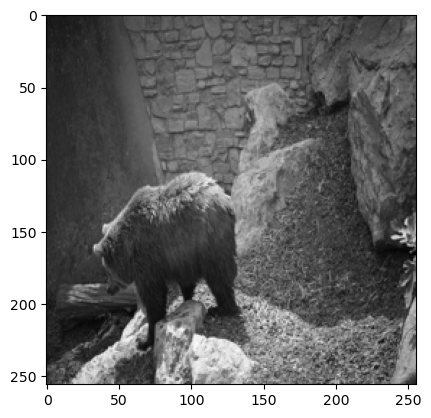

In [9]:
plt.imshow(davis_bear_ds[0][0].permute(1, 2, 0))

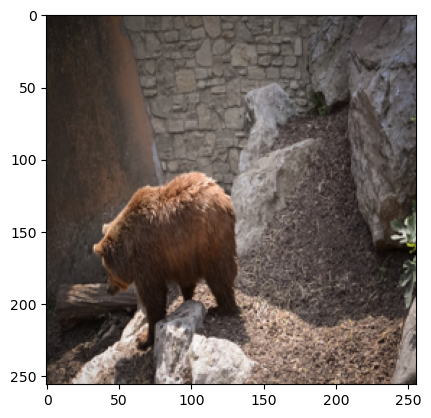

In [10]:
plt.imshow(davis_bear_ds[0][1].permute(1, 2, 0))

In [11]:
inp = davis_bear_ds[0][0].unsqueeze(0).to("cuda")
out = model(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


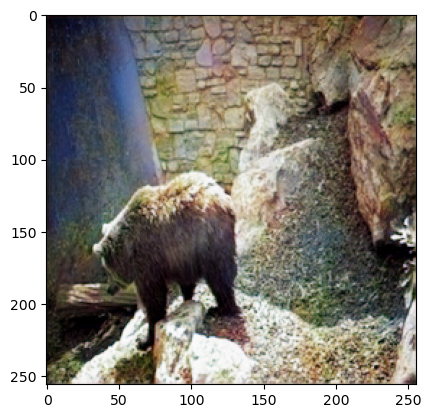

In [12]:
out: torch.Tensor
out = out.detach()[0].cpu()
plt.imshow(out.permute(1, 2, 0))

## Inference on DAVIS dataset

In [13]:
DAVIS_PATH = Path("/home/salkhon/repo/colorization/data/DAVIS/JPEGImages/480p/")

OUTPUT_PATH = Path("/home/salkhon/repo/colorization/output") / MODEL_NAME
OUTPUT_PATH.mkdir(exist_ok=True)

In [14]:
davis_ds = ImageDataset(DAVIS_PATH)

In [15]:
for img_idx in tqdm(range(len(davis_ds))):
    inp = davis_ds[img_idx][0].unsqueeze(0).to("cuda")
    out = model(inp)
    out: torch.Tensor = out.detach()[0].cpu()
    out = torch.clip(out, 0, 1)
    inp_path = davis_ds.data_paths[img_idx]
    out_path = OUTPUT_PATH / inp_path.relative_to(DAVIS_PATH)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    transforms.ToPILImage()(out).save(out_path)

100%|██████████| 6208/6208 [25:07<00:00,  4.12it/s]


# Frame vs PSNR

In [16]:
# Function to compute PSNR between two images
def psnr(img1: torch.Tensor, img2: torch.Tensor) -> float:
    mse = torch.mean((img1 - img2) ** 2)
    return (20 * torch.log10(1.0 / torch.sqrt(mse))).squeeze().item()

In [17]:
gt = davis_ds[0][1]
out = model(davis_ds[0][0].unsqueeze(0).to("cuda"))
out: torch.Tensor
out = out.detach()[0].cpu()
psnr_val = psnr(gt, out)
print(psnr_val)

21.664051055908203


In [18]:
import pandas as pd

dfs: dict[str, dict[str, list]] = {}
for img_idx in tqdm(range(len(davis_ds))):
    gt = davis_ds[img_idx][1]
    out_path = OUTPUT_PATH / davis_ds.data_paths[img_idx].relative_to(DAVIS_PATH)
    category = out_path.parent.name
    out = transforms.ToTensor()(Image.open(out_path))
    out: torch.Tensor
    
    psnr_val = psnr(gt, out)

    if category not in dfs:
        dfs[category] = { "image": [], "psnr": [] }

    dfs[category]["image"].append(out_path.name)
    dfs[category]["psnr"].append(psnr_val)

  0%|          | 15/6208 [00:00<04:41, 22.01it/s]

100%|██████████| 6208/6208 [03:21<00:00, 30.84it/s]


In [19]:
print(dfs)

{'crossing': {'image': ['00014.jpg', '00043.jpg', '00018.jpg', '00040.jpg', '00028.jpg', '00045.jpg', '00022.jpg', '00008.jpg', '00020.jpg', '00012.jpg', '00006.jpg', '00004.jpg', '00033.jpg', '00027.jpg', '00049.jpg', '00000.jpg', '00007.jpg', '00039.jpg', '00011.jpg', '00042.jpg', '00034.jpg', '00038.jpg', '00005.jpg', '00026.jpg', '00047.jpg', '00050.jpg', '00029.jpg', '00019.jpg', '00031.jpg', '00009.jpg', '00044.jpg', '00048.jpg', '00023.jpg', '00024.jpg', '00016.jpg', '00002.jpg', '00032.jpg', '00025.jpg', '00030.jpg', '00015.jpg', '00051.jpg', '00037.jpg', '00021.jpg', '00010.jpg', '00041.jpg', '00013.jpg', '00001.jpg', '00003.jpg', '00036.jpg', '00035.jpg', '00017.jpg', '00046.jpg'], 'psnr': [21.274459838867188, 21.696413040161133, 21.38019371032715, 21.29380989074707, 21.280277252197266, 21.69706153869629, 21.126203536987305, 21.55360984802246, 21.28370475769043, 21.64398193359375, 21.5625, 21.595943450927734, 21.17479133605957, 21.328079223632812, 21.89265251159668, 21.658702

In [22]:
# save timeseries for each category
for category, data in dfs.items():
    df = pd.DataFrame(data, columns=["image", "psnr"])
    # save plot of psnr column over time
    df.plot(title=f"PSNR over time for {category}")
    plt.savefig(OUTPUT_PATH / category / f"{category}.png")
    plt.close()
    # save frame vs psnr values as csv
    df.set_index("image", inplace=True)
    df.sort_index(inplace=True)
    df.to_csv(OUTPUT_PATH / category / f"{category}.csv")

# Color Distribution Consistency (CDC)

In [63]:
import scipy

def color_distribution_consistency(img1: torch.Tensor, img2: torch.Tensor) -> float:
    img1 = img1.permute(1, 2, 0).reshape(-1, 3)
    img2 = img2.permute(1, 2, 0).reshape(-1, 3)
    img1 = torch.mean(img1, dim=0)
    img2 = torch.mean(img2, dim=0)
    dist = scipy.spatial.distance.cdist(img1.unsqueeze(0), img2.unsqueeze(0)).flatten()[0]
    return dist

In [64]:
categories = list(dfs.keys())
cdc = 0
for category in categories:
    CAT_PATH = OUTPUT_PATH / category
    IMG_PATHS = sorted(CAT_PATH.rglob("*.jpg"))
    consecutive_pairs = zip(IMG_PATHS[:-1], IMG_PATHS[1:])
    for img1_path, img2_path in consecutive_pairs:
        img1 = transforms.ToTensor()(Image.open(img1_path))
        img2 = transforms.ToTensor()(Image.open(img2_path))
        cdc += color_distribution_consistency(img1, img2)

cdc /= len(davis_ds)
print(cdc)

0.0023332823744567468
